Group 20 members:
- Janick Michot:          michojan@students.zhaw.ch
- Andre von Aarburg :     andre.vonaarbrug@ost.ch
- Manuel Weiss:           weissman@students.zhaw.ch

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tabulate
import pandas as pd

## Linear Regression

Using the rent prices from appartments in Lausanne from PW 02, restricting to the feature living area.

### Load Data

In [2]:
import pandas as pd
df = pd.read_csv("./lausanne-appart.csv")
N  = df.shape[0]
df.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


### Normalization

In [3]:
# Standard normalization https://en.wikipedia.org/wiki/Normalization_(statistics)

x0 = df.values[:,0]
x = (x0-np.mean(x0))/np.std(x0)
y0 = df.values[:,2]
y = (y0-np.mean(y0))/np.std(y0)

Text(0, 0.5, 'rent_price')

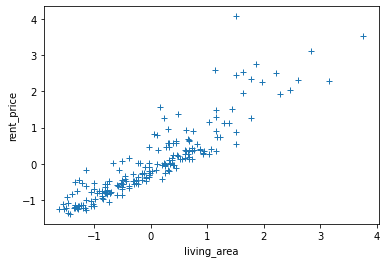

In [4]:
plt.plot(x, y,"+")
plt.xlabel("living_area")
plt.ylabel("rent_price")

### Linear Model, Normal Equations and Solution

We denote the observed rent by $y_j$ (at time $x_j$) and the model rent by $\hat{y}_j$ we assume 

$\qquad \hat{y}_j = \alpha + \beta x_j$

By minimizing the mean squares error

$\qquad C = \frac{1}{2N}\sum_j \left(y_j-\hat{y}_j\right)^2 = C(\alpha,\beta)$

we can fit the straigth line as follows by using the design matrix $X$ and the data vector $Y$, defined by 

$\qquad X = \left(\begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_{N-1}\end{array}\right), \qquad Y = \left(\begin{array}{c} y_0\\ \vdots \\ y_{N-1}\end{array}\right)$

We find 

$\qquad \left(\begin{array}{c}\alpha \\ \beta\end{array}\right) = \left(X^T\cdot X\right)^{-1}\cdot X^T\cdot Y$

Hence, here we can easily compute the (linear) model which best fits the training data in the sense of obtaining a minimal mean square error. 

### Solution of Normal Equations in Pytorch

In [5]:
N = x.size
               
# YOUR CODE (START)
# compose torch tensors X,Y of shape (N,2) and (N,1) respectively
X = torch.cat((torch.ones((N, 1)), torch.tensor(x).reshape(-1, 1)), dim=1)
Y = torch.tensor(y).reshape(-1, 1)

a = torch.inverse(X.T @ X) @ X.T @ Y

print(a)

# YOUR CODE (END)

tensor([[-1.9602e-16],
        [ 9.0425e-01]], dtype=torch.float64)


tensor([[-1.9602e-16],
        [ 9.0425e-01]], dtype=torch.float64)


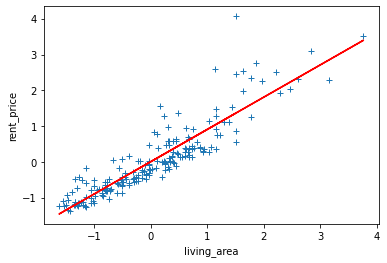

In [8]:
N = x.size

# YOUR CODE (START)
# compose torch tensors X,Y of shape (N,2) and (N,1) respectively
X = torch.cat((torch.ones((N, 1)), torch.tensor(x).reshape(-1, 1)), dim=1)
Y = torch.tensor(y).reshape(-1, 1)

# solution of normal equations, 'a' a torch tensor of shape (2,1) that contains parameters alpha and beta, which shall be optimized
a = torch.inverse(X.T @ X) @ X.T @ Y

# alternative with lstsq

# prediction
Yhat = a[1, 0] * X[:, 1]+ a[0, 0]

# YOUR CODE (END)

# plot
plt.plot(X[:,1],Y,"+")
plt.plot(X[:,1],Yhat,'r')
plt.xlabel("living_area")
plt.ylabel("rent_price")
print(a)

plt.show()

Note that with the pytorch function `torch.lstsq` you can obtain the same.

#### Cost

In [6]:
def cost(X,Y,a):
    # YOUR CODE (START)
    return (1/N)*sum([((a[0, 0] + a[1,0]*X[i,1])-Y[i])**2 for i in range(N)]).item()
    # YOUR CODE (END)

In [7]:
cost_closed_form = cost(X,Y,a)
print(cost_closed_form)

0.18233305879162034


### Gradient Descent

Specify the gradient of the cost (w.r.t. $\alpha, \beta$) here as maths expression.

In [8]:
def gradient_cost(X,Y,a):
    # YOUR CODE (START)
    return -X.T@(Y-X@a)/N
    # YOUR CODE (END)

Last minimum cost 0.1823330587916203


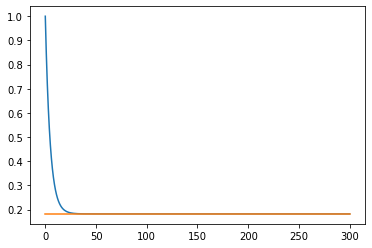

In [9]:
# adjust if needed
nepochs = 300
lr = 0.1

## initial parameter
a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)

# track the costs
costs = [cost(X,Y,a)]

# YOUR CODE (START)
a = torch.tensor([0.0, 0.0], dtype=torch.float64).reshape(2,1)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    a = a - lr * gradient_cost(X, Y, a)
    costs.append(cost(X,Y,a))

# YOUR CODE (END)
    
# some output
cost_gd = costs[-1]
plt.plot(range(nepochs+1),costs)
plt.plot(range(nepochs+1),cost_closed_form*torch.ones(nepochs+1))

print("Last minimum cost", costs[len(costs) - 1])

### Different Learning Rates

Play with different learning rates: Explore for what learning rates
- the learning is most efficient
- the learning yet works
- the learning does not work anymore (learning rate too large)

Explain the different scenarios.

In [16]:
target = 0.18233305879162034
deviation = 1 * 10**-20
nepochs = 300
initial_lr=0.1
lr_step=0.1
n_step = 25
initial_a = torch.tensor([0.0,0.0], dtype=torch.float64).reshape(2,1)

def efficiency_test(initial_a, initial_lr, lr_step):
    lr = initial_lr
    count = 0
    counts = pd.DataFrame(columns=['lr', 'count'])
    for i in range(n_step):
        costs = [cost(X,Y,initial_a)]
        count = 0
        a = initial_a
        while abs(target - costs[len(costs)-1]) > deviation and count < nepochs:
            a = a - lr * gradient_cost(X, Y, a)
            costs.append(cost(X,Y,a))
            count += 1
        counts.loc[len(counts.index)] = [lr, count]
        counts.reset_index(drop=True)
        lr += lr_step
    display(counts)
    

efficiency_test(initial_a, initial_lr, lr_step)
        
    

,lr,count
0,0.1,173.0
1,0.2,84.0
2,0.3,54.0
3,0.4,45.0
4,0.5,34.0
5,0.6,21.0
6,0.7,30.0
7,0.8,25.0
8,0.9,8.0
9,1.0,1.0


### Interpretation
In order to play with the learning rates we wrote the above simulation.
The displayed table shows the result of different learning rates and the count of how many iterations it took until to get close enough to the calculated target value. According to our simulation the answers to the questions are the following:

Play with different learning rates: Explore for what learning rates
- the learning is most efficient
    - With a learning rate of 1 (by a learning rate change of 0.1)
- the learning yet works
    - In our tests we came to the minmum with a maximum learning rate of 1.9
- the learning does not work anymore (learning rate too large)
    - With a learning rate 2 and above we couldn't reach the minimum anymore or at least not within 300 iterations